# Sentiment Analysis with other transformer models

In [1]:
# mount your google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:
<br>**AutoModel and AutoTokenizer are used to work with various transformer models.**

In [2]:
!pip install -qq transformers

In [3]:
#@title Setup & Config
import transformers
from transformers import AutoModel, BertModel, AutoTokenizer, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the reviews dataset:

In [4]:
# upload data/rt-polaritydata/reviews_with_splits_lite.csv on your google drive

df = pd.read_csv("/content/drive/MyDrive/rnn-transformer-sentiment/rnn-transformer-sentiment/data/rt-polaritydata/reviews_with_splits_lite.csv")
df.head()

,rating,review,split
0,negative,the film has a few cute ideas and several mode...,train
1,negative,i'm not saying that ice age doesn't have some ...,train
2,negative,the worst film of the year . \n,train
3,negative,what can one say about a balding 50-year-old a...,train
4,negative,it's supposed to be post-feminist breezy but e...,train


In [5]:
df.shape

(10662, 3)

In [6]:
class_names = ['negative', 'positive']

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [7]:
# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'roberta-base'
# PRE_TRAINED_MODEL_NAME = 'distilroberta-base'
# try out additional models, such as roberta-base, distilroberta-base, and albert-base-v2 in https://huggingface.co/models
# note that some models do not work with this code, such as xlnet-base-cased; distilbert-base-cased; gpt2; xlnet-base-cased; xlm-mlm-en-2048

Let's load a pre-trained [AutoTokenizer:](https://huggingface.co/transformers/model_doc/auto.html#autotokenizer)
In many cases, the architecture you want to use can be guessed from the name or the path of the pretrained model you are supplying to the from_pretrained() method. AutoClasses are here to do this job for you so that you automatically retrieve the relevant model given the name/path to the pretrained weights/config/vocabulary.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

We'll use this text to understand the tokenization process:

### Choosing Sequence Length

Transformer modle works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [9]:
token_lens = []

for txt in df.review:
  tokens = tokenizer(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens['input_ids']))

and plot the distribution:

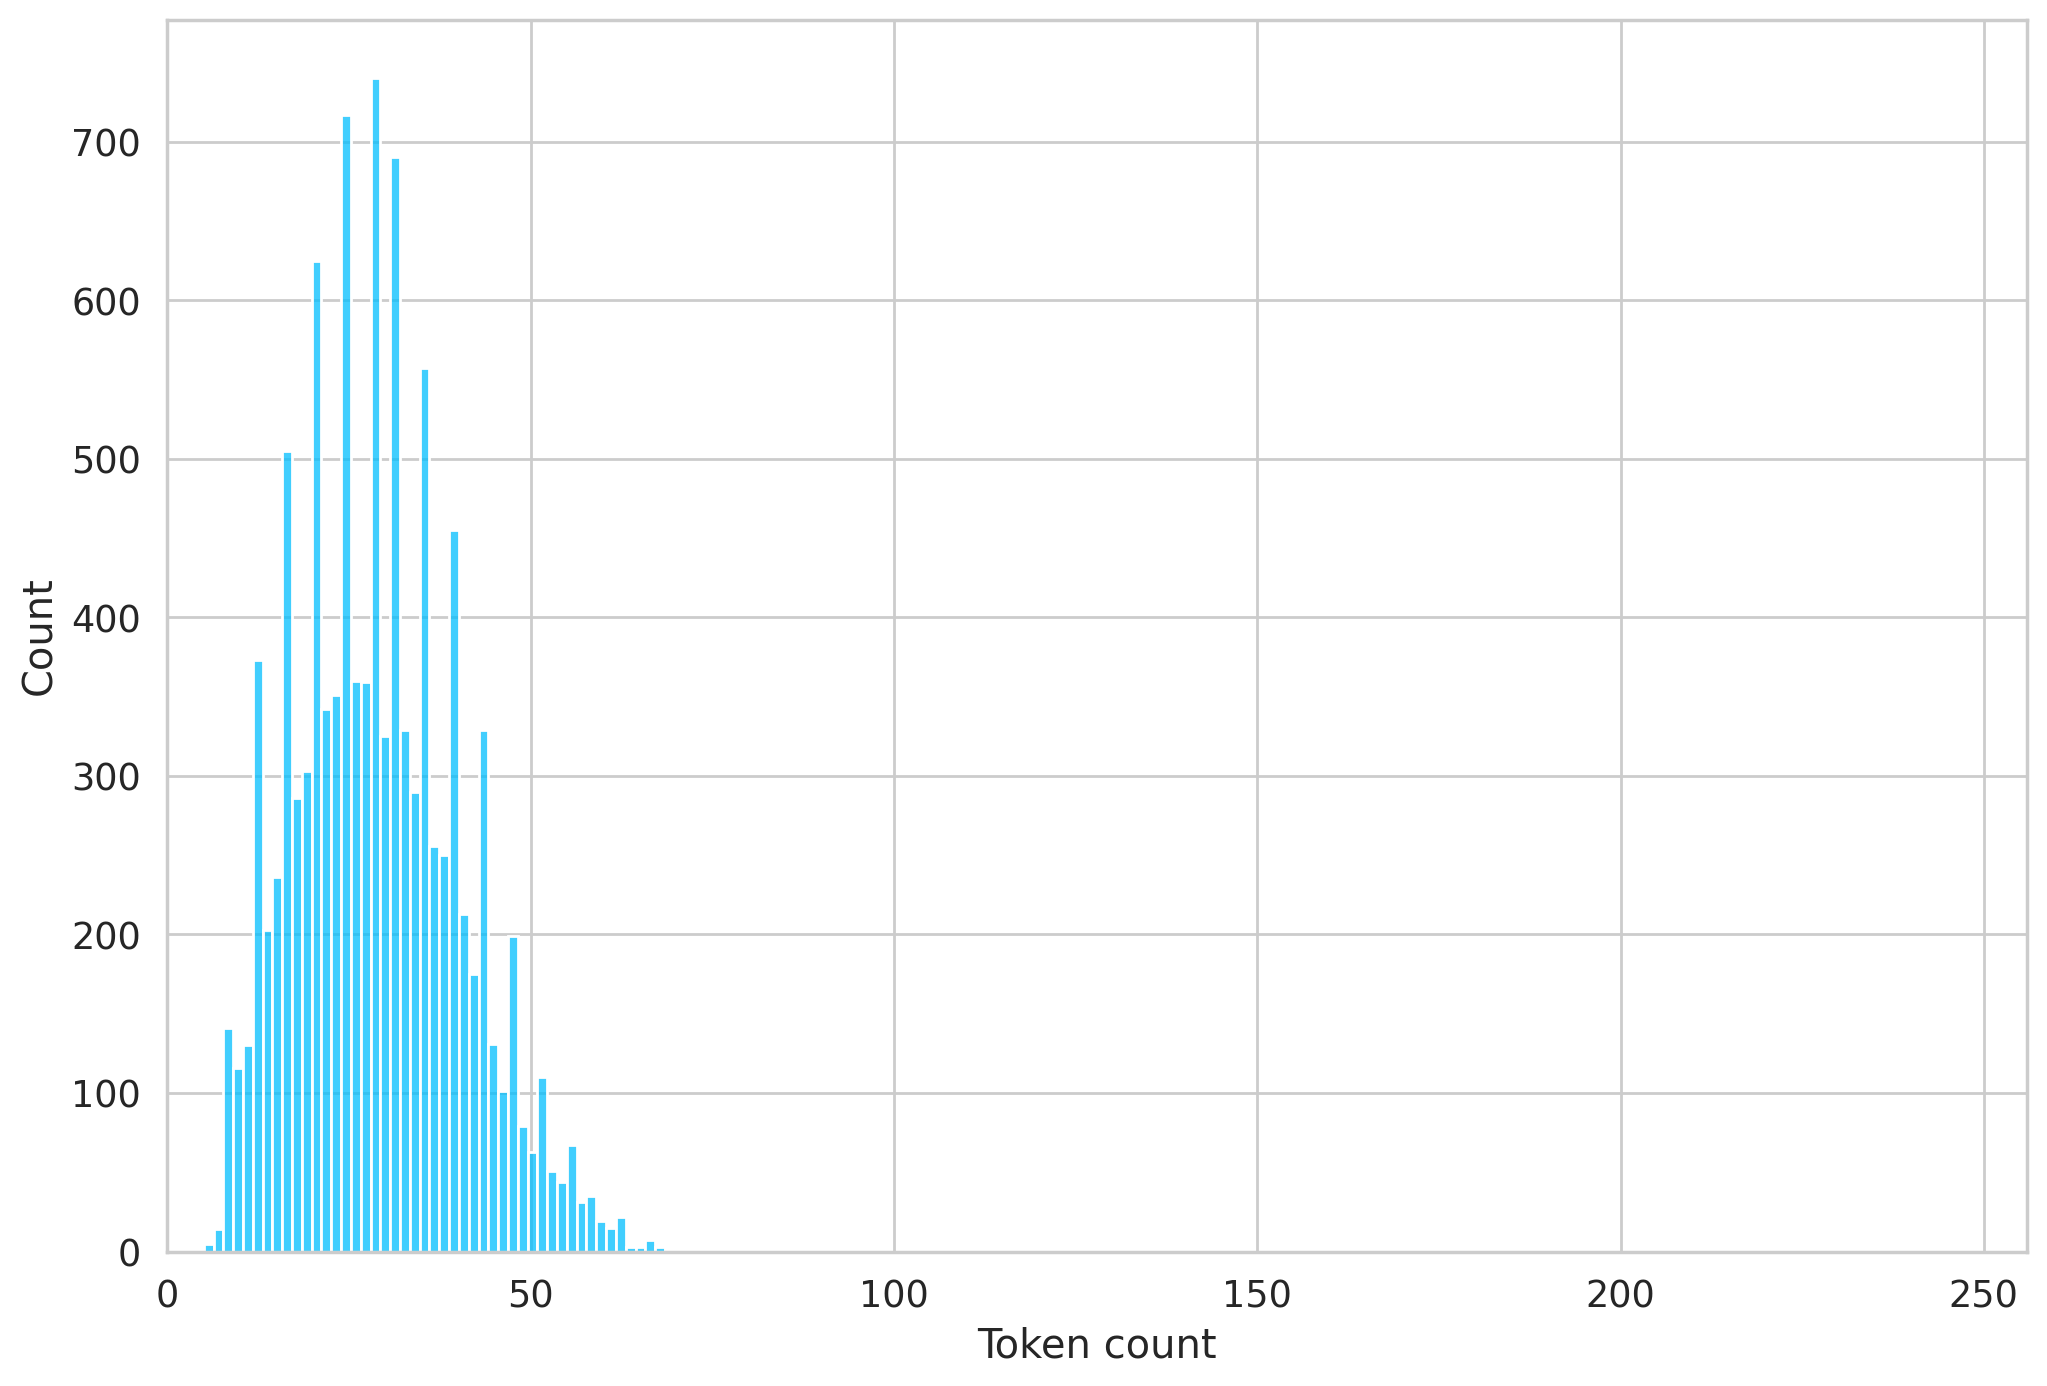

In [10]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 70 tokens, but we'll be on the safe side and choose a maximum length of 80.

In [11]:
MAX_LEN = 80

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [12]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    if target == 'negative':
       target = 0
    else:
       target = 1

    encoding = self.tokenizer(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [13]:
df_train = df[df.split=="train"]
df_val = df[df.split=="val"]
df_test = df[df.split=="test"]

In [14]:
df_train.shape, df_val.shape, df_test.shape

((7466, 3), (1598, 3), (1598, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:
- Truncation: Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided.

In [15]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review.to_numpy(),
    targets=df.rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4, #  process hangs with num_workers=4
    num_workers=0,  #  num_workers: how many subprocesses to use for data loading. 0 means that the data will be
                   #  loaded in the main process. (default: 0)
    shuffle=True   # , drop_last=True
  )

In [16]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

## Sentiment Classification with Transformer models

There are a lot of helpers that make using Transformer models easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else.

But who cares, right? We're *hardcore*! We'll use the basic [AutoModel](https://huggingface.co/transformers/model_doc/auto.html#automodel) and build our sentiment classifier on top of it. Let's load the model:

We can use all of this knowledge to create a classifier that uses the BERT model:

In [17]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs.pooler_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [18]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We'll move the example batch of our training data to the GPU:

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [19]:
EPOCHS = 10

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [20]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [22]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc.cpu().detach().numpy())
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc.cpu().detach().numpy())
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_test.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.40685772526467967 accuracy 0.813420841146531
Val   loss 0.3426909290254116 accuracy 0.8560700876095119

Epoch 2/10
----------
Train loss 0.24286148654153714 accuracy 0.9117331904634343
Val   loss 0.28782104231417177 accuracy 0.8898623279098874

Epoch 3/10
----------
Train loss 0.1745987830635829 accuracy 0.9385212965443344
Val   loss 0.3554288882762194 accuracy 0.8829787234042553

Epoch 4/10
----------
Train loss 0.10629646744853698 accuracy 0.965711224216448
Val   loss 0.36232678696513176 accuracy 0.902377972465582

Epoch 5/10
----------
Train loss 0.0852513735055223 accuracy 0.9764264666488081
Val   loss 0.5109893490560353 accuracy 0.9011264080100125

Epoch 6/10
----------
Train loss 0.053180570895141825 accuracy 0.9858023037771231
Val   loss 0.6562878701090813 accuracy 0.8911138923654568

Epoch 7/10
----------
Train loss 0.034077488808817044 accuracy 0.9908920439324941
Val   loss 0.6689666818047408 accuracy 0.8948685857321652

Epoch 8/10
----------

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

We can look at the training vs validation accuracy:

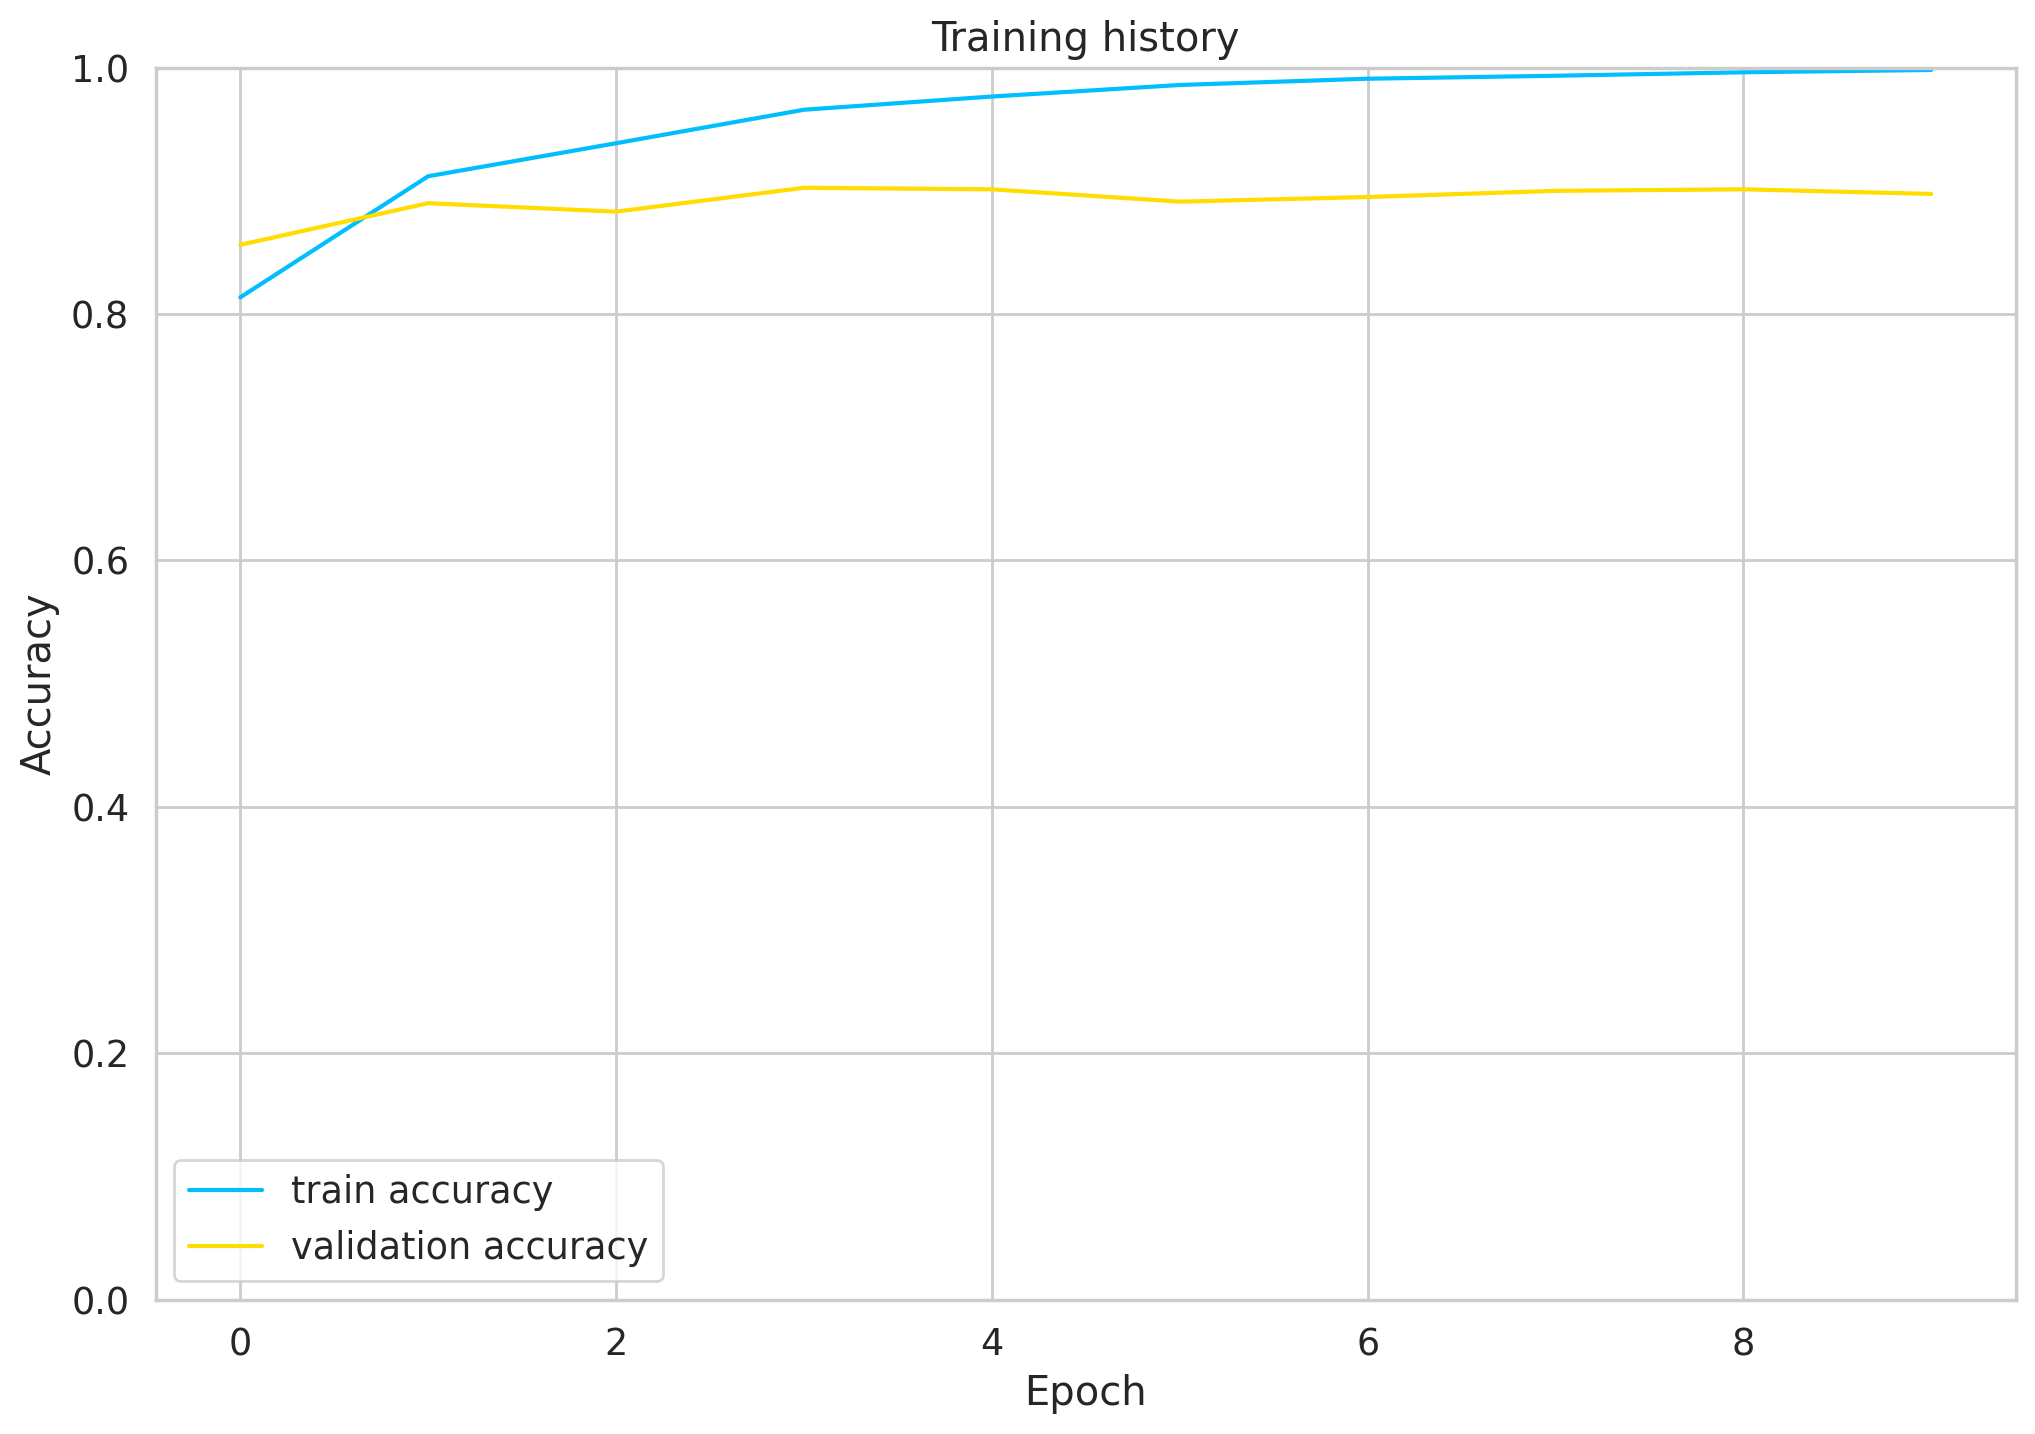

In [23]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [24]:
model.load_state_dict(torch.load('best_model_state_test.bin', weights_only=False))  # load the best model
model = model.to(device)

test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item(), test_loss.item()

(0.8898623279098874, 0.370203939601779)

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [25]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [26]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let's have a look at the classification report

In [27]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89       799
    positive       0.88      0.90      0.89       799

    accuracy                           0.89      1598
   macro avg       0.89      0.89      0.89      1598
weighted avg       0.89      0.89      0.89      1598



We'll continue with the confusion matrix:

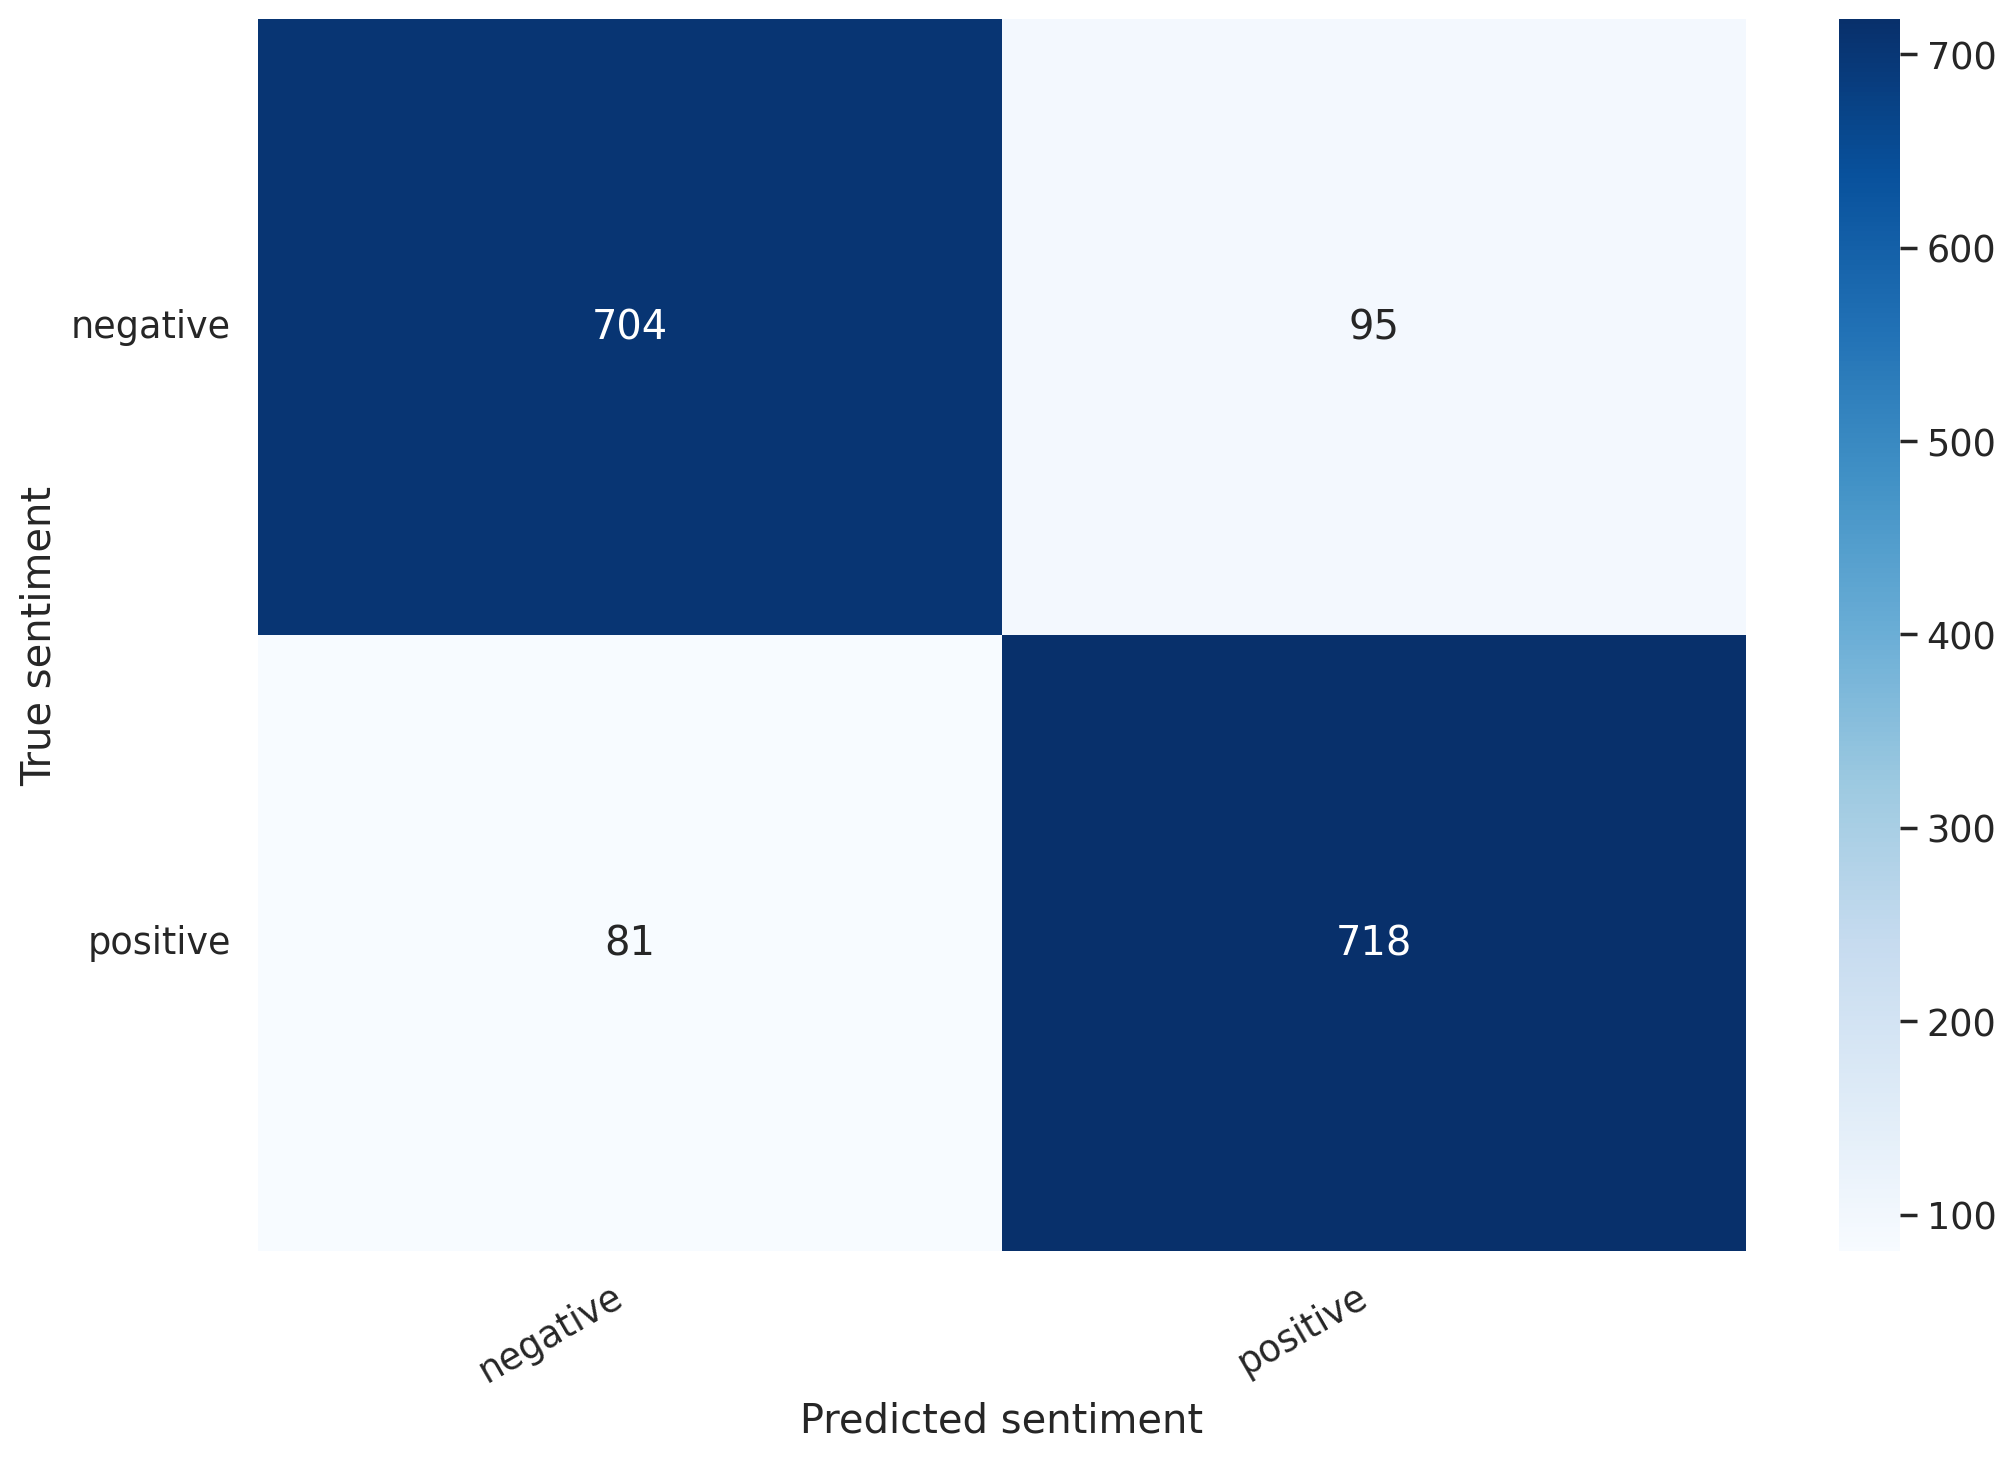

In [28]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [29]:
idx = 3

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [30]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

roman coppola may never become the filmmaker his dad was , but heck –
few filmmakers will . but based on cq , i'll certainly be keeping an
eye out for his next project .

True sentiment: positive


Now we can look at the confidence of each sentiment of our model:

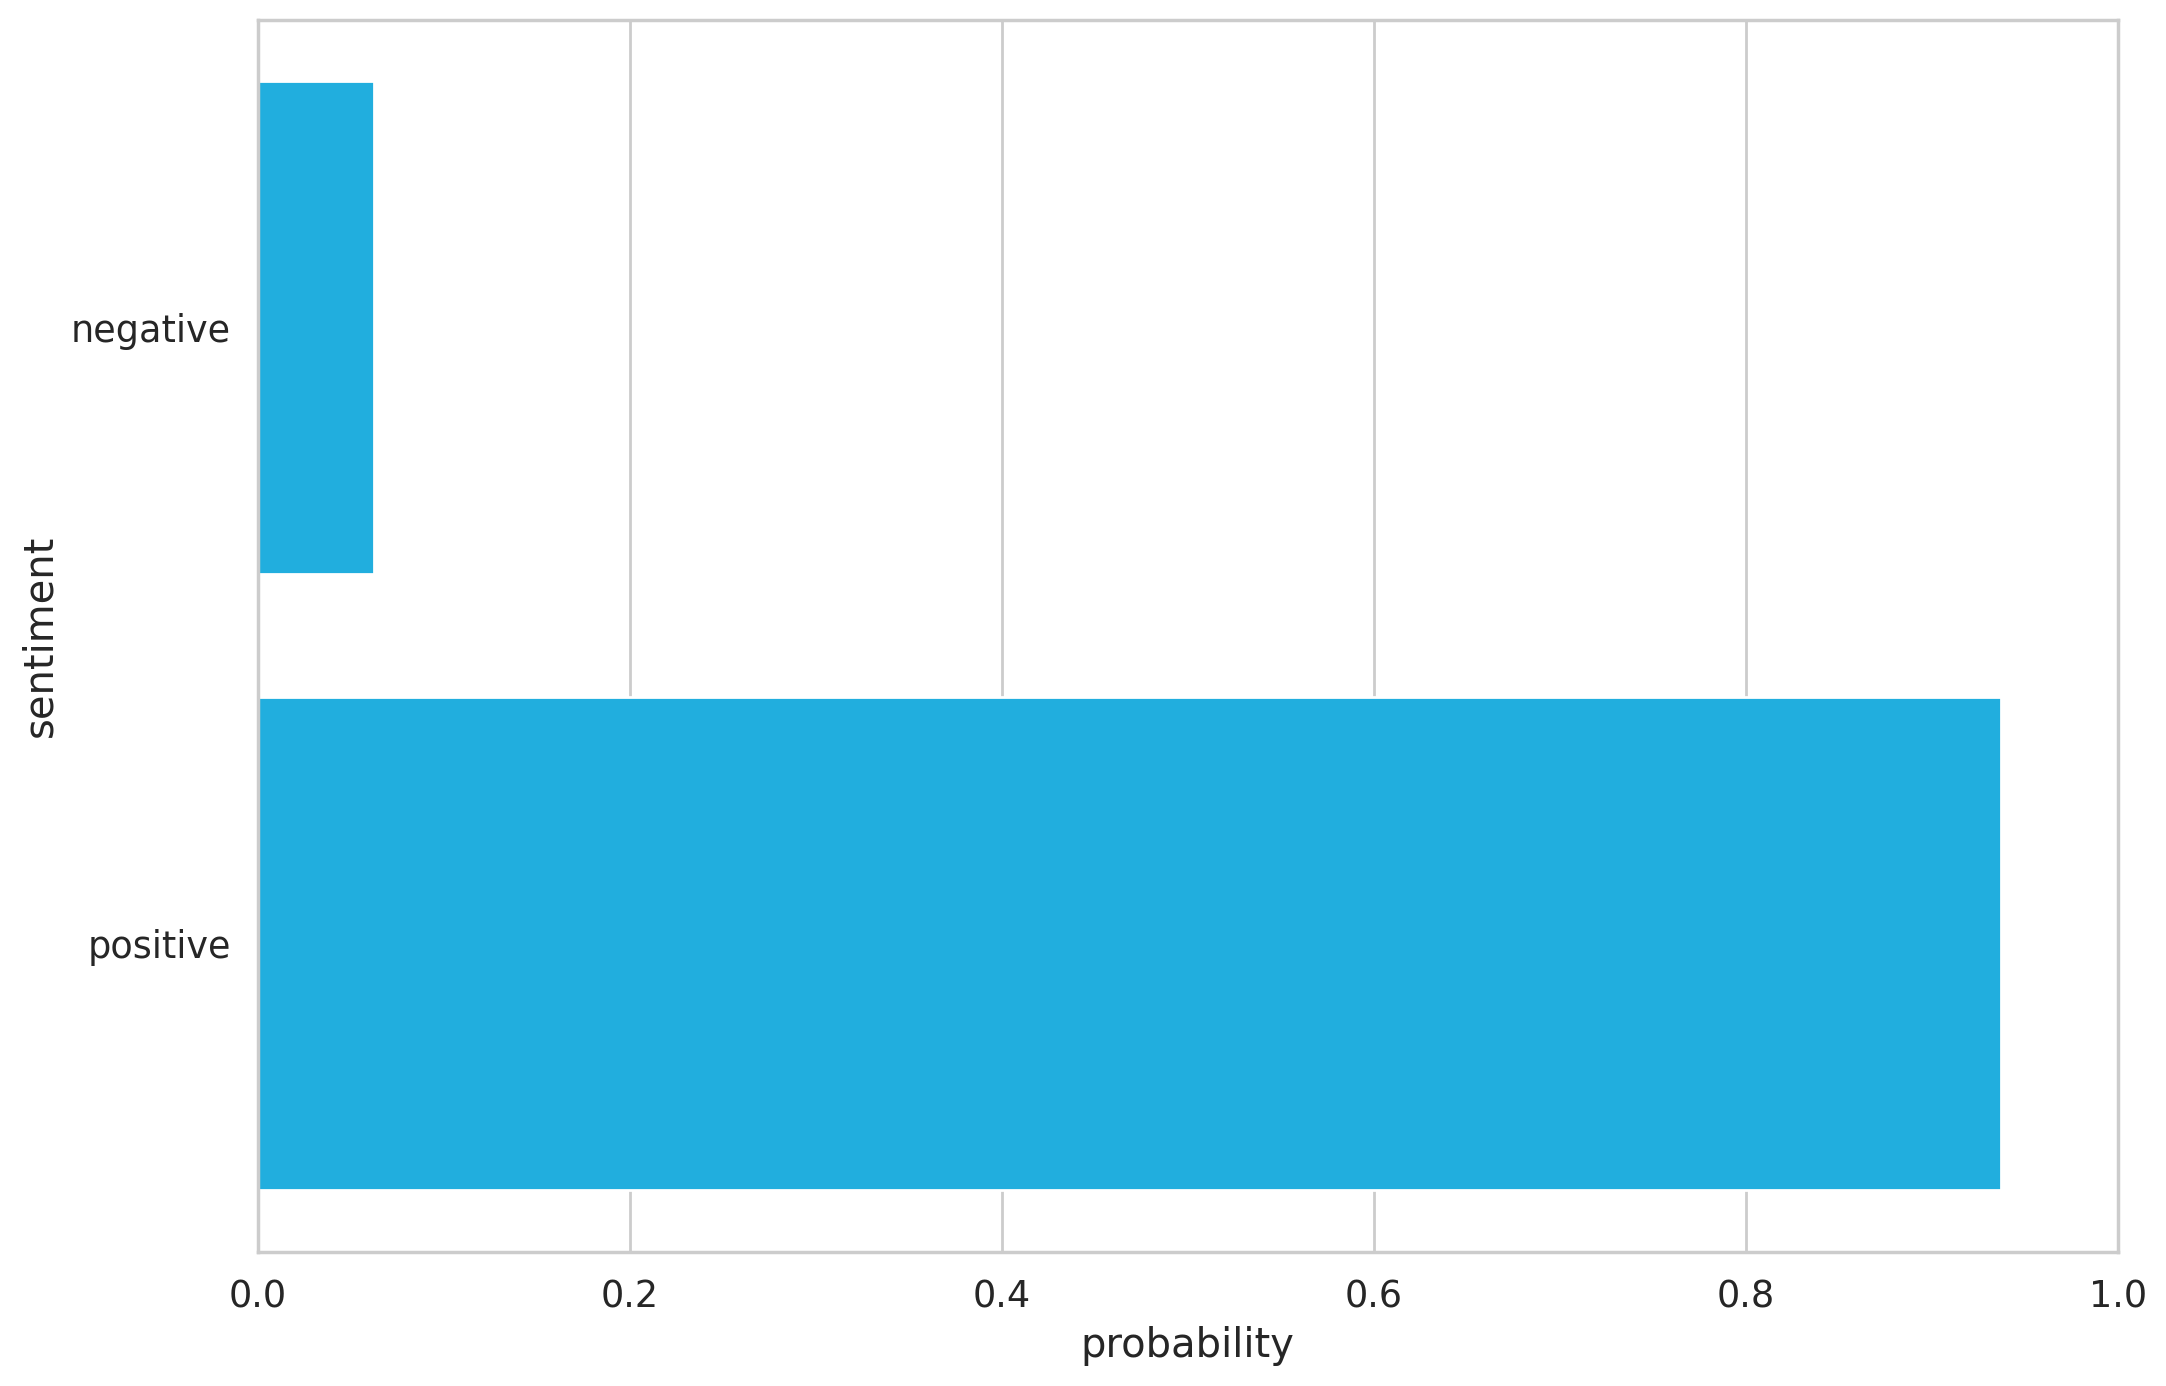

In [31]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [32]:
review_text = "I love completing my todos! Best app ever!!!"

In [33]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Let's get the predictions from our model:

In [34]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : positive
